In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
import pickle
import os
import time
import datetime
from matplotlib import patches
import multi_tracker_analysis as mta
import scipy.stats
import figurefirst as fifi
import pandas
import copy
import flystat
import fly_plot_lib.plot as fpl
import matplotlib.patches as mpatches

/home/caveman/.local/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


1.5.1
recommended version: 1.1.1 or greater


In [2]:
from numpy import random, histogram2d, diff
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d

In [3]:
def load_data():
    df = pandas.read_hdf('data/flydata_20210428_3cam.hdf', 'flydata_20210428_3cam')


    minimum_req_visits = 3
    flids_okay = []
    for flid in df.flid.unique():
        dfq = df[df.flid==flid]
        if len(dfq) >= minimum_req_visits:
            flids_okay.append(flid)
    df = df[df.flid.isin(flids_okay)]

    df.fraction_of_time_near_odor += 1e-4 # to help with logs

    # spatial novelty
    new_camera = []
    for ix in range(len(df)):
        nc = 1
        try:
            if df.iloc[ix].flid == df.iloc[ix-1].flid:
                if df.iloc[ix].camera != df.iloc[ix-1].camera:
                    nc = 2
            else:
                nc = 2
        except:
            nc = 2 # first one
        new_camera.append(nc)
    df['new_camera'] = new_camera

    # nth visit
    nth_visit = [1]
    for ix in range(1, len(df)):
        if df.iloc[ix].flid == df.iloc[ix-1].flid:
            nth_visit.append(nth_visit[-1]+1)
        else:
            nth_visit.append(1)
    df['nth_visit'] = nth_visit
    df['log_nth_visit'] = np.log(nth_visit)

    df['mean_interval'] = np.nanmean([df['interval'].values, df['interval2'].values], axis=0)
    df['approached_odor'] = np.sign(df['fraction_of_time_near_odor']-0.01)

    df['camera_num'] = (df['camera'] == 'center_camera')
    df['camera_num'] = (df['camera_num'] -1) /2

    return df

In [4]:
df = load_data()
df = df[ ~ (df.nth_visit==1) ] # drop the first visits for this analysis
df = df[df.interval > 0] # there is one encoutner with a negative interval
#df.fraction_of_time_near_odor += 1e-4 # to help with logs

In [14]:
#fig = plt.figure()
#ax = fig.add_subplot(111)

distances_travelled = []
angles_of_landing = []
approach_stats = []
intervals = []
fraction_of_time_downwind = []

upwind = 0
downwind = 0
for i in range(len(df)):
    try:
        data = pandas.read_hdf('data/' + df['all_trajec_ids'][i])
        #ax.scatter(data.pos_x_mm[0], -1*data.pos_y_mm[0], c=df['approached_odor'][i], 
        #           cmap='bone_r', vmin=-1, vmax=1, s=5, linewidth=0.25)
    except:
        data = None
    
    if data is not None:
        angles_from_downwind = [np.abs( np.arctan2(data.pos_y_mm[f], np.abs(data.pos_x_mm[f]) )*180/np.pi - 90 ) for f in range(len(data.pos_y_mm))] 

        fraction_of_time_downwind.append( float(sum(np.array(angles_from_downwind) > 45))/len(angles_from_downwind) )

        approach_stats.append(df['approached_odor'][i])
        distances_travelled.append(df['distance_travelled'][i])
        intervals.append(df['interval'][i])




LinregressResult(slope=0.0700648397943746, intercept=6.166257297312838, rvalue=0.02206018712991723, pvalue=0.7951337425895756, stderr=0.2693257266432805)


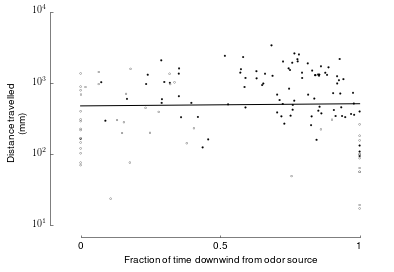

In [23]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_subplot(111)

ax.scatter(fraction_of_time_downwind, np.log(distances_travelled), 
           c=approach_stats, s=3, linewidth=0.25,rasterized=True, cmap='bone_r')

x = np.linspace(np.min(fraction_of_time_downwind), np.max(fraction_of_time_downwind), 100)

r = scipy.stats.linregress(fraction_of_time_downwind, np.log(distances_travelled))
print(r)
y = r.slope*x + r.intercept

plt.plot(x,y, color='black')


yticks = [10**1, 10**2, 10**3, 10**4]
yticklabels = ['$10^1$', '$10^2$', '$10^3$', '$10^4$']

xticks = [0, 0.5, 1]
xticklabels = [0, 0.5, 1]

ax.set_xlim(-0.1, 1.1)

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'], 
                                 yticks=np.log(yticks), 
                                 xticks=xticks,
                                 linewidth=0.5, tick_length=2.5, 
                                 spine_locations={'left': 2.5, 'bottom': 2.5})
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(xticklabels)
ax.minorticks_off()

ax.set_xlabel('Fraction of time downwind from odor source')
ax.set_ylabel('Distance travelled\n(mm)')

fig.savefig('fraction_of_time_downwind.pdf')

In [25]:
0.022**2

0.00048399999999999995